In [1]:
import pandas as pd
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from math import ceil
from tqdm import tqdm
import gradio as gr
import os
import gc
from PIL import Image
from torch.cuda.amp import autocast, GradScaler

/home/tulitanir/efficientnet_test/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


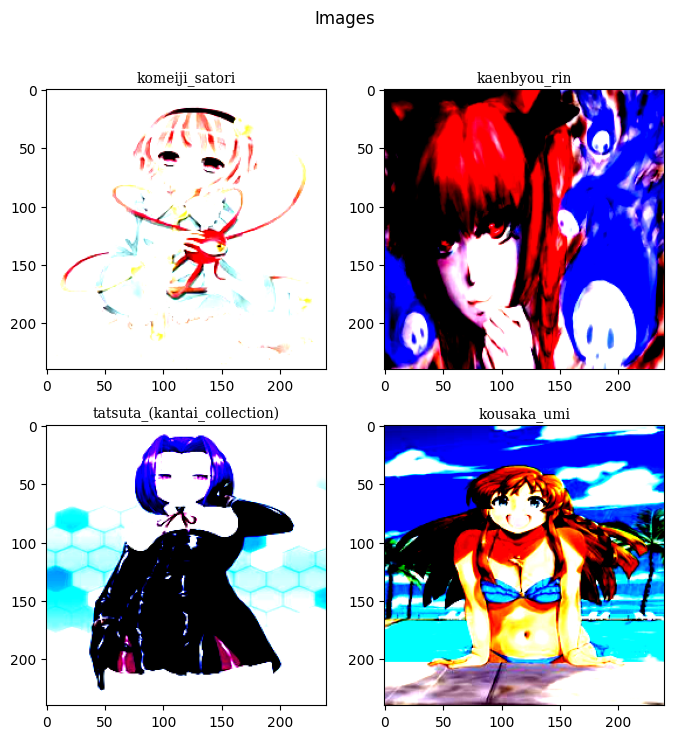

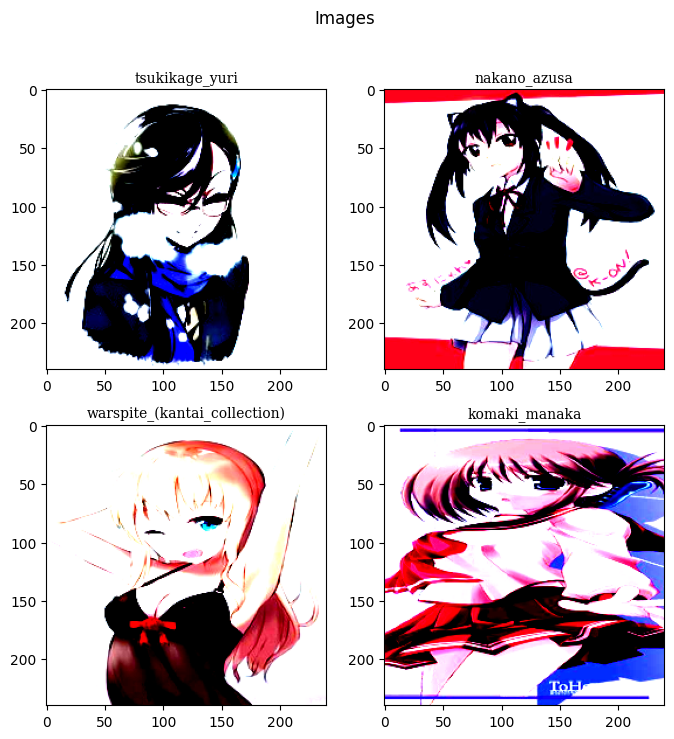

In [2]:
config = {
    'train': 'dataset/labels/train.csv',
    'test': 'dataset/labels/val.csv',
    'classnames': 'dataset/labels/classid_classname.csv',
    'image_root_path': 'dataset/fullMin256'
}

efficient_net_config = {
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    # "b2" : (1.1, 1.2, 260, 0.3),
    # "b3" : (1.2, 1.4, 300, 0.3),
    # "b4" : (1.4, 1.8, 380, 0.4),
    # "b5" : (1.6, 2.2, 456, 0.4),
    # "b6" : (1.8, 2.6, 528, 0.5),
    # "b7" : (2.0, 3.1, 600, 0.5)
}

image_size = 240
num_classes = 3263
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = None
batch_size = 64

def read_image(root_path, path):
    return torchvision.io.read_image(os.path.join(root_path, path)) / 255.0

class CustomDataset(Dataset):
    def __init__(self, config, train=True):
        self.dataframe = pd.read_csv(config['train']) if train else pd.read_csv(config['test'])
        self.transforms = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
    
        image = read_image(config['image_root_path'], self.dataframe.iloc[index]['path'])
        image = self.transforms(image)
        class_id = torch.tensor(self.dataframe.iloc[index]['class_id'])
        return image, class_id

train_dataset = CustomDataset(config)

test_dataset = CustomDataset(config, False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

def check_loader(loader):
    dataframe = pd.read_csv(config['classnames'])
    
    (img, label) = next(iter(loader))
    _, ax = plt.subplots(2, 2, figsize=(8, 8))
    plt.suptitle('Images')
    index = 0
    for i in range(2):
        for j in range(2):
            csv_index = label[index].item()
            title = dataframe.iloc[csv_index]['class_name']
            ax[i][j].imshow((img[index].permute(1, 2, 0)))
            ax[i][j].set_title(title, fontfamily='serif', fontsize='medium')
            index+= 1
            
check_loader(train_dataloader)
check_loader(test_dataloader)

In [3]:
class CNNBlock(nn.Module):

    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(CNNBlock, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
class SqueezeExcitation(nn.Module):
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.seq = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        y = self.seq(x)
        return x * y
    
class StochasticDepth(nn.Module):
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):   
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
    
class MBConvN(nn.Module):
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else CNNBlock(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = CNNBlock(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = CNNBlock(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x

In [4]:
class EfficientNet(nn.Module):
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = num_classes):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [CNNBlock(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(CNNBlock(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)


In [5]:
def plot(num_of_epochs, track_training, track_test, save_path, loss=True):
    label_end = 'Loss' if loss else 'Accuracy'
    plt.plot(range(1, num_of_epochs+2), track_training, label=f'Training {label_end}')
    plt.plot(range(1, num_of_epochs+2), track_test, label=f'Testing {label_end}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{label_end}')
    plt.title(f'Training and testing {label_end}')
    plt.legend()
    
    path = os.path.join(save_path, 'plots')
    if not os.path.exists(path):
        os.makedirs(path)
        
    plt.savefig(os.path.join(path, f'{num_of_epochs}_{label_end}_plots.png'))
    plt.close()
    
def save_model(model, name, epoch, accuracy, loss, save_path):
    additional_info = {
        'epoch': epoch,
        'loss': loss,
        'accuracy': accuracy
    }
    
    path = os.path.join(save_path, 'models')
    if not os.path.exists(path):
        os.makedirs(path)
        
    path = os.path.join(path, f'{name}_{epoch}.pth')
        
    torch.save({
            'model_state_dict': model.state_dict(),
            'additional_info': additional_info
        },      
        path
    )
    
def get_checkpoints(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pth')]

checkpoint_directory = "checkpoints"

checkpoints = get_checkpoints(checkpoint_directory)
    
def unload_model(model):
    model.cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    return 'Модель выгружена из памяти'
    
def load_model(path):
    checkpoint = torch.load(path)
    version = 'b1'
    width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
    model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = num_classes)
    model = model.to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def inference(image, model, image_size):
    transformations = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
    image = transformations(image).to(device)
    image = image[None, :, :, :]
    with torch.no_grad():
        outputs = model(image)
    probs = F.softmax(outputs[0], dim=0)
    
    dataframe = pd.read_csv(config['classnames'])
        
    preds, indexes = torch.topk(probs, k=5)
    return {dataframe.iloc[i.item()]['class_name']: p.item() for i, p in zip(indexes, preds)}
    

In [6]:
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    running_loss = 0
    running_accuracy = 0
    
    for (inputs, labels) in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / size_of_dataset
    epoch_accuracy = running_accuracy / size_of_dataset
    print(f'Test Loss: {epoch_loss:.4f} Test Acc.: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy

In [7]:
def train(lr, epoch_num, train_csv_path, test_csv_path, classnames_csv_path, image_root_path, model_name, save_path, pr=gr.Progress(track_tqdm=True)):
    config = {
        'train': train_csv_path,
        'test': test_csv_path,
        'classnames': classnames_csv_path,
        'image_root_path': image_root_path
    }
    
    version = 'b1'
    width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
    model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = num_classes)
    model = model.to(device)
    
    scaler = GradScaler()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epoch_num)
    
    train_dataset = CustomDataset(config)

    test_dataset = CustomDataset(config, False)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    
    track_training_loss = []
    track_test_loss = []
    track_training_accuracy = []
    track_test_accuracy = []

    for epoch in range(epoch_num):
        loop = tqdm(train_dataloader, desc="Прогресс текущей эпохи", leave=True)
        print(f'\nEpoch {epoch + 1}/{epoch_num}')
        print('-'*30)

        model.train()
        running_loss = 0
        running_accuracy = 0

        for _, (inputs, labels) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            with autocast(dtype=torch.bfloat16):
                outputs = model(inputs)
                _ , preds = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
            
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = running_accuracy / len(train_dataset)
        
        track_training_accuracy.append(epoch_accuracy.item())
        track_training_loss.append(epoch_loss)

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')
        model.eval()

        test_loss, test_accuracy = calculate_loss_and_accuracy(model, test_dataloader, len(test_dataset), criterion)
        track_test_loss.append(test_loss)
        track_test_accuracy.append(test_accuracy.item())
        
        plot(epoch, track_training=track_training_loss, track_test=track_test_loss, save_path=save_path)
        plot(epoch, track_training=track_training_accuracy, track_test=track_test_accuracy, save_path=save_path, loss=False)
        save_model(model=model, name=model_name, epoch=epoch, accuracy=test_accuracy, loss=test_loss, save_path=save_path)
        
    unload_model(model)
    print(f"Training with lr={lr}, epoch_num={epoch_num}, epoch_num={epoch_num}, train_csv_path={train_csv_path}, test_csv_path={test_csv_path}, classnames_csv_path={classnames_csv_path}, image_root_path={image_root_path}, model_name={model_name}, save_path={save_path}")
    return f"Обучение модели {model_name} завершено"
        

In [8]:
current_model = None

def set_model_and_resolution(checkpoint):
    global current_model
    if current_model is not None:
        unload_model(current_model)
    current_model = load_model(checkpoint)
    return f"Загружена модель из чекпоинта {checkpoint}"

with gr.Blocks() as infer:
    
    with gr.Row():
        checkpoint_dropdown = gr.Dropdown(choices=checkpoints, label="Выберите чекпоинт")
        load_button = gr.Button("Загрузка модели")
        load_output = gr.Textbox(label="Статус", interactive=False)
    
    load_button.click(fn=set_model_and_resolution, inputs=[checkpoint_dropdown], outputs=[load_output])
    
    with gr.Row():
        image_input = gr.Image(type="pil", image_mode="RGB", label="Загрузите изображение", sources=['clipboard'])
        output = gr.Label(label="Предсказания")
        run_button = gr.Button("Определить класс")
    
    def run_inference(image_info):
        return inference(image_info, current_model, 240)
    
    run_button.click(fn=run_inference, inputs=[image_input], outputs=output)
    
lr_input = gr.Number(label="Скорость обучения")
num_of_epochs_input = gr.Number(label="Количество эпох")
train_csv_input = gr.File(label="CSV файл с обучающими данными")
test_csv_input = gr.File(label="CSV файл с тестовыми данными")
classnames_csv_input = gr.File(label="CSV файл с именами классов")
image_root_path_input = gr.Textbox(label="Корневой путь к изображениям")
model_name_input = gr.Textbox(label="Название модели")
save_path_input = gr.Textbox(label="Путь для сохранения модели")
    
train = gr.Interface(
    fn=train,
    inputs=[lr_input, num_of_epochs_input, train_csv_input, test_csv_input, classnames_csv_input, image_root_path_input, model_name_input, save_path_input],
    outputs="text",
    title="Интерфейс для обучения модели",
    description="Введите параметры для начала обучения модели",
    submit_btn="Начать обучение",
    clear_btn="Очистить"
)


demo = gr.TabbedInterface([infer, train], ["Классификация", "Обучение"])
demo.launch()

TypeError: BlockContext.__init__() got an unexpected keyword argument 'output'